# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

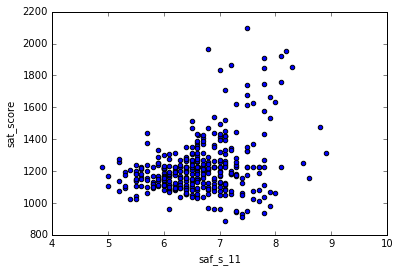

In [10]:
%matplotlib inline
combined.plot.scatter(x='saf_s_11',y='sat_score')

In [11]:
districts=combined.groupby('school_dist').aggregate(np.mean)
districts.reset_index(inplace=True)

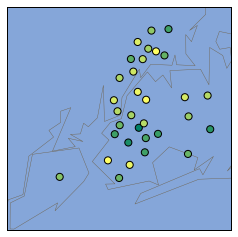

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes=districts['lon'].tolist()
latitudes=districts['lat'].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True, c=districts['saf_s_11'],cmap='summer')


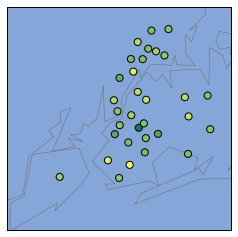

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes=districts['lon'].tolist()
latitudes=districts['lat'].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True, c=districts['saf_t_11'],cmap='summer')
plt.show()


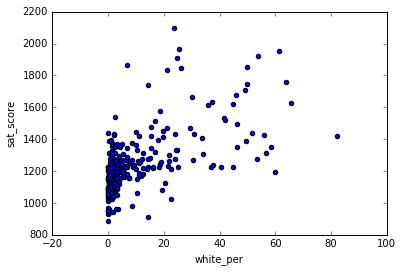

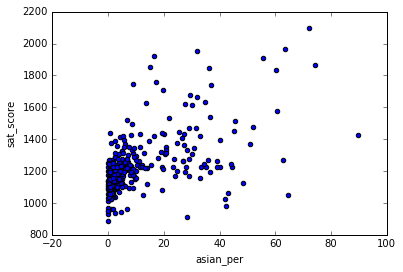

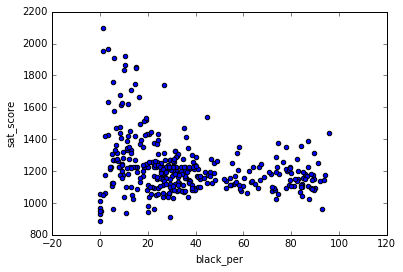

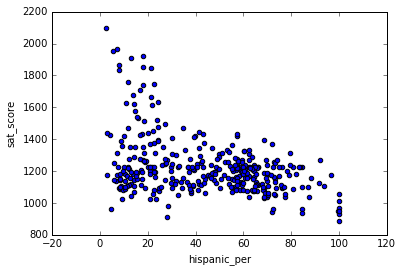

In [14]:
cols=['white_per','asian_per','black_per','hispanic_per']
for col in cols:
    combined.plot.scatter(x=col,y='sat_score')

**There is definitely a trend for hispanic_per with sat_score. There is a negative correlation. There is a cluster of low sat_score for high hispanic_per. Even though there is a trend the trend is not very clear. There is also a cluster of very low sat_score with respect to hispanic_per.**

In [15]:
nine_hispanic_per=combined[combined['hispanic_per']>95]

In [16]:
nine_hispanic_per['SCHOOL NAME'].unique()

array(['MANHATTAN BRIDGES HIGH SCHOOL',
       'WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL',
       'GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS',
       'ACADEMY FOR LANGUAGE AND TECHNOLOGY',
       'INTERNATIONAL SCHOOL FOR LIBERAL ARTS',
       'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE',
       'MULTICULTURAL HIGH SCHOOL',
       'PAN AMERICAN INTERNATIONAL HIGH SCHOOL'], dtype=object)

In [17]:
nine_hispanic_per['sat_score']

44     1058.0
82     1174.0
89     1014.0
125     951.0
141     934.0
176     970.0
253     887.0
286     951.0
Name: sat_score, dtype: float64

In [18]:
ten_hispanic_per=combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]

In [19]:
ten_hispanic_per['SCHOOL NAME'].unique()

array(['STUYVESANT HIGH SCHOOL', 'BRONX HIGH SCHOOL OF SCIENCE',
       'BROOKLYN TECHNICAL HIGH SCHOOL',
       'QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE',
       'STATEN ISLAND TECHNICAL HIGH SCHOOL'], dtype=object)

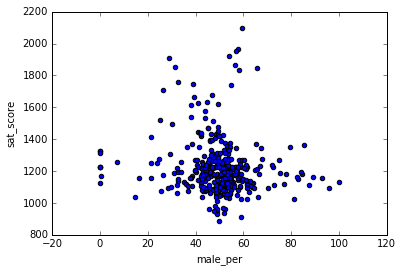

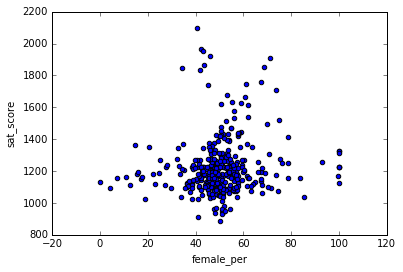

In [20]:
cols=['male_per','female_per']

for col in cols:
    combined.plot.scatter(x=col,y='sat_score')

**There is a somewhat linear trend in both of the scatter plot except there are clusters around 40-60% where the SAT scores are in the approximate range from  1000-1400.**

In [21]:
female_sat_sixty=combined[(combined['female_per']>60) & (combined['sat_score'] > 1700)]

In [22]:
female_sat_sixty['SCHOOL NAME'].unique()

array(['BARD HIGH SCHOOL EARLY COLLEGE', 'ELEANOR ROOSEVELT HIGH SCHOOL',
       'BEACON HIGH SCHOOL',
       'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS',
       'TOWNSEND HARRIS HIGH SCHOOL'], dtype=object)

In [23]:
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']

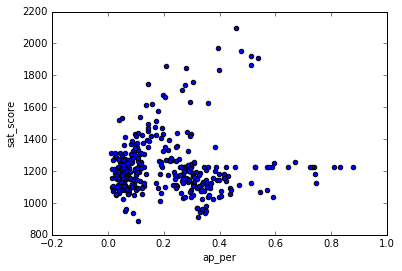

In [24]:
combined.plot.scatter(x='ap_per',y='sat_score')

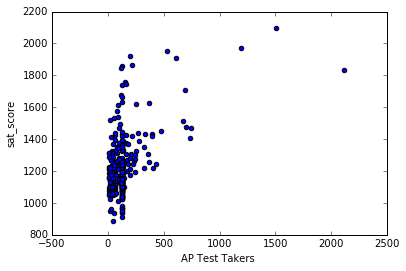

In [25]:
combined.plot.scatter(x='AP Test Takers ',y='sat_score')

In [26]:
ap_per_small=combined[(combined['ap_per']<0.4) & (combined['sat_score']<1400)]

In [27]:
ap_per_small['SCHOOL NAME'].unique()

array(['HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES',
       'UNIVERSITY NEIGHBORHOOD HIGH SCHOOL', 'EAST SIDE COMMUNITY SCHOOL',
       'MARTA VALLE HIGH SCHOOL', 'FOOD AND FINANCE HIGH SCHOOL',
       'ESSEX STREET ACADEMY', 'HIGH SCHOOL OF HOSPITALITY MANAGEMENT',
       'PACE HIGH SCHOOL',
       'URBAN ASSEMBLY SCHOOL OF DESIGN AND CONSTRUCTION, THE',
       'FACING HISTORY SCHOOL, THE',
       'URBAN ASSEMBLY ACADEMY OF GOVERNMENT AND LAW, THE',
       'LOWER MANHATTAN ARTS ACADEMY',
       'URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WOMEN, THE',
       'GRAMERCY ARTS HIGH SCHOOL', 'MANHATTAN BUSINESS ACADEMY',
       'LANDMARK HIGH SCHOOL',
       'HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN SERVICES',
       'LEADERSHIP AND PUBLIC SERVICE HIGH SCHOOL',
       'MANHATTAN VILLAGE ACADEMY', 'VANGUARD HIGH SCHOOL',
       'MANHATTAN INTERNATIONAL HIGH SCHOOL',
       'HIGH SCHOOL OF ECONOMICS AND FINANCE',
       'MURRY BERGTRAUM HIGH SCHOOL FOR BUSINESS CAREERS',
       'JACQU

In [28]:
ap_per_big=combined[(combined['ap_per']<0.4) & (combined['sat_score']>1400)]

In [29]:
ap_per_big['SCHOOL NAME'].unique()

array(['NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND MATH HIGH SCHOOL',
       'BARD HIGH SCHOOL EARLY COLLEGE', 'NYC ISCHOOL',
       'HIGH SCHOOL FOR ENVIRONMENTAL STUDIES',
       'PROFESSIONAL PERFORMING ARTS HIGH SCHOOL',
       'BARUCH COLLEGE CAMPUS HIGH SCHOOL',
       'N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES',
       'N.Y.C. MUSEUM SCHOOL', 'ELEANOR ROOSEVELT HIGH SCHOOL',
       'MILLENNIUM HIGH SCHOOL', 'TALENT UNLIMITED HIGH SCHOOL',
       'HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES',
       'BEACON HIGH SCHOOL',
       'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS',
       'MANHATTAN / HUNTER SCIENCE HIGH SCHOOL',
       'MANHATTAN CENTER FOR SCIENCE AND MATHEMATICS',
       'HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE',
       'BRONX HIGH SCHOOL OF SCIENCE', 'BROOKLYN TECHNICAL HIGH SCHOOL',
       'BROOKLYN LATIN SCHOOL, THE',
       'MEDGAR EVERS COLLEGE PREPARATORY SCHOOL',
       'EDWARD R. MURROW HIGH SCHOOL

In [30]:
ap_per_big_=combined[(combined['ap_per']>0.4) & (combined['sat_score']<1400)]

In [31]:
ap_per_big_['SCHOOL NAME'].unique()

array(['47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECONDARY SCHOOL',
       'BUSINESS OF SPORTS SCHOOL',
       'THE HIGH SCHOOL FOR LANGUAGE AND DIPLOMACY',
       'MANHATTAN ACADEMY FOR ARTS & LANGUAGE',
       'HUDSON HIGH SCHOOL OF LEARNING TECHNOLOGIES',
       'INTERNATIONAL HIGH SCHOOL AT UNION SQUARE',
       'UNITY CENTER FOR URBAN TECHNOLOGIES',
       'REPERTORY COMPANY HIGH SCHOOL FOR THEATRE ARTS',
       'HUMANITIES PREPARATORY ACADEMY',
       'THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS',
       'FRANK MCCOURT HIGH SCHOOL', 'HERITAGE SCHOOL, THE',
       'HIGH SCHOOL FOR EXCELLENCE AND INNOVATION',
       'COMMUNITY SCHOOL FOR SOCIAL JUSTICE', 'BRONX BRIDGES HIGH SCHOOL',
       'THE CINEMA SCHOOL',
       'BRONX CAREER AND COLLEGE PREPARATORY HIGH SCHOOL',
       'FRANCES PERKINS ACADEMY',
       'EL PUENTE ACADEMY FOR PEACE AND JUSTICE',
       'THE BROOKLYN ACADEMY OF GLOBAL FINANCE',
       'ACADEMY OF HOSPITALITY AND TOURISM',
       'KURT HAHN EXPEDITIONARY LEARNI

In [32]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority06', 'priority07', 'priority08', 'priority09', 'priority10',
       'Location 1', 'lat', 'lon', 'school_dist', 'ap_per'],
      dtype='object', length=161)

In [33]:
'class_size' in combined.columns

False

In [34]:
class_size.columns

Index(['DBN', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS',
       'SCHOOLWIDE PUPIL-TEACHER RATIO'],
      dtype='object')

In [35]:
'AVERAGE CLASS SIZE' in combined.columns

True

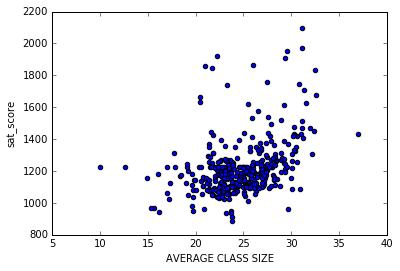

In [36]:
combined.plot.scatter(x='AVERAGE CLASS SIZE',y='sat_score')

In [37]:
av_twenty_small=combined[(combined['AVERAGE CLASS SIZE']>20) & (combined['sat_score']>1400)]

In [38]:
av_twenty_small.shape

(42, 161)

In [39]:
len(av_twenty_small['DBN'].unique())

42

In [40]:
combined.shape

(363, 161)

In [41]:
av_twenty_big=combined[(combined['AVERAGE CLASS SIZE']>20) & (combined['sat_score']<=1400)]

In [42]:
av_twenty_big.shape

(293, 161)

In [43]:
av_below_twenty=combined[(combined['AVERAGE CLASS SIZE']<=20) & (combined['sat_score']>1400)]

In [44]:
av_below_twenty.shape

(0, 161)

In [45]:
av_below_twentyfive=combined[(combined['AVERAGE CLASS SIZE']<=25) & (combined['sat_score']>1400)]

In [46]:
av_below_twentyfive.shape

(8, 161)

In [47]:
av_below_twentyfive['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
64                MANHATTAN / HUNTER SCIENCE HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
198                           BROOKLYN LATIN SCHOOL, THE
287                    BARD HIGH SCHOOL EARLY COLLEGE II
346            BACCALAUREATE SCHOOL FOR GLOBAL EDUCATION
Name: SCHOOL NAME, dtype: object

In [48]:
S=combined.groupby('SCHOOL NAME').aggregate(np.mean)

In [49]:
S.reset_index(inplace=True)

In [50]:
S

,SCHOOL NAME,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,ap_per
0,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,395.000000,400.000000,387.000000,1182.000000,129.028846,197.038462,153.450,25.000000,2,...,12.0,10010,184.0,1,0,0,0,40.738599,-73.982512,0.741545
1,A. PHILIP RANDOLPH CAMPUS HIGH SCHOOL,430.000000,456.000000,423.000000,1309.000000,165.000000,222.000000,72.000,267.000000,6,...,12.0,10031,1360.0,4,0,0,0,40.818321,-73.950614,0.128405
2,ABRAHAM LINCOLN HIGH SCHOOL,396.000000,437.000000,393.000000,1226.000000,133.000000,193.000000,18.000,620.000000,21,...,12.0,11235,2313.0,6,0,0,0,40.582308,-73.967466,0.051252
3,ACADEMY FOR CAREERS IN TELEVISION AND FILM,410.000000,440.000000,405.000000,1255.000000,129.028846,197.038462,153.450,193.870968,30,...,12.0,11101,470.0,1,0,0,0,40.741137,-73.949689,0.307945
4,ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...,396.000000,374.000000,369.000000,1139.000000,64.000000,82.000000,7.000,69.000000,17,...,12.0,11226,532.0,1,0,0,0,40.649440,-73.958431,0.113274
5,ACADEMY FOR CONSERVATION AND THE ENVIRONMENT,363.000000,381.000000,367.000000,1111.000000,129.028846,197.038462,153.450,193.870968,18,...,12.0,11236,280.0,1,0,0,0,40.632627,-73.917798,0.470908
6,ACADEMY FOR ENVIRONMENTAL LEADERSHIP,380.000000,366.000000,352.000000,1098.000000,129.028846,197.038462,153.450,99.000000,32,...,12.0,11237,352.0,1,0,0,0,40.696962,-73.910816,0.356433
7,ACADEMY FOR LANGUAGE AND TECHNOLOGY,315.000000,339.000000,297.000000,951.000000,20.000000,20.000000,20.000,193.870968,9,...,12.0,10453,301.0,3,0,0,0,40.849102,-73.916088,0.059524
8,ACADEMY FOR SCHOLARSHIP AND ENTREPRENEURSHIP: ...,386.000000,394.000000,361.000000,1141.000000,24.000000,24.000000,153.450,65.000000,11,...,12.0,10466,437.0,1,0,0,0,40.887919,-73.852872,0.039604
9,ACADEMY FOR SOCIAL ACTION: A COLLEGE BOARD SCHOOL,354.000000,366.000000,342.000000,1062.000000,17.000000,17.000000,153.450,193.870968,5,...,12.0,10027,309.0,1,0,0,0,40.815230,-73.955201,0.040000


In [51]:
Bard=S[S['SCHOOL NAME']=='BARD HIGH SCHOOL EARLY COLLEGE']

In [52]:
Bard

,SCHOOL NAME,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,ap_per
28,BARD HIGH SCHOOL EARLY COLLEGE,624.0,604.0,628.0,1856.0,129.028846,197.038462,153.45,139.0,1,...,12.0,10002,560.0,1,0,0,0,40.718962,-73.976066,0.209123


In [54]:
combined_sty_bard=combined[(combined['SCHOOL NAME']=='BARD HIGH SCHOOL EARLY COLLEGE') | (combined['SCHOOL NAME']=='STUYVESANT HIGH SCHOOL')]

In [61]:
combined_sty_bard.head(7)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01,0.209123
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.000000,2819.000000,...,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02,0.457992


In [62]:
combined['SCHOOL NAME'].value_counts()

YOUNG WOMEN'S LEADERSHIP SCHOOL                                                   2
ACADEMY OF FINANCE AND ENTERPRISE                                                 1
ASTOR COLLEGIATE ACADEMY                                                          1
QUEENS VOCATIONAL AND TECHNICAL HIGH SCHOOL                                       1
EXPLORATIONS ACADEMY                                                              1
LEADERSHIP AND PUBLIC SERVICE HIGH SCHOOL                                         1
LIFE SCIENCES SECONDARY SCHOOL                                                    1
MANHATTAN CENTER FOR SCIENCE AND MATHEMATICS                                      1
COALITION SCHOOL FOR SOCIAL CHANGE                                                1
BRONX THEATRE HIGH SCHOOL                                                         1
GROVER CLEVELAND HIGH SCHOOL                                                      1
THE URBAN ASSEMBLY SCHOOL FOR LAW AND JUSTICE                               

In [64]:
data['sat_results']['SCHOOL NAME'].value_counts()

GOTHAM PROFESSIONAL ARTS ACADEMY                                         1
BENJAMIN BANNEKER ACADEMY                                                1
SCHOOL FOR HUMAN RIGHTS, THE                                             1
CASCADES HIGH SCHOOL                                                     1
NEW DESIGN HIGH SCHOOL                                                   1
SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE HIGH SCHOOL AT ERASMUS    1
FANNIE LOU HAMER FREEDOM HIGH SCHOOL                                     1
PAN AMERICAN INTERNATIONAL HIGH SCHOOL                                   1
HARLEM RENAISSANCE HIGH SCHOOL                                           1
LEADERSHIP INSTITUTE                                                     1
LYONS COMMUNITY SCHOOL                                                   1
HIGH SCHOOL OF WORLD CULTURES                                            1
INTERNATIONAL HIGH SCHOOL AT LAGUARDIA COMMUNITY COLLEGE                 1
BROOKLYN BRIDGE ACADEMY  